In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
from datasets import load_dataset

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
torch.cuda.empty_cache()

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [5]:
from dotenv import load_dotenv
load_dotenv()

os.chdir(os.getenv("PROJECT_ROOT_DIR"))
print(os.getcwd())

/root/malicious-code-detection


In [6]:
def read_data(path):
	with open(path, "r") as f:
		data = f.readlines()
		vectors = [token for token in data]
		return vectors


In [7]:
class Config:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [9]:
print("Loading data")



Loading data


In [12]:
def tok(example):
    encodings = tokenizer(example['text'], truncation=True, padding=True, max_length=512)
    return encodings

def convert_labels_to_long(example):
    example['label'] = int(example['label'])  # Convert to integer if it's not
    return example

train_dataset = load_dataset("./", data_files={'train': "data/exp/train_set.parquet"},  split="train", streaming=True)
# train_dataset.add_column("label", train_labels)
val_dataset = load_dataset("./", data_files={'train': "data/exp/test_set.parquet"}, split="train", streaming=True)
# val_dataset.add_column("label", test_labels)

train_dataset = train_dataset.map(convert_labels_to_long)
val_dataset = val_dataset.map(convert_labels_to_long)

train_dataset = train_dataset.map(tok, batched=True, batch_size=32)
val_dataset = val_dataset.map(tok, batched=True, batch_size=32)

train_dataset = train_dataset.with_format("torch")
val_dataset = val_dataset.with_format("torch")

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [14]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2).to(Config.DEVICE)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Load pre-trained CodeBERT model and add a classification layer
# 2 classes: benign, malicious

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    save_total_limit=2,
	max_steps=int(1e6),
)


# Define training arguments and set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [16]:
# Train the model
trainer.train()

# Evaluation
predictions, labels, _ = trainer.predict(val_dataset)
predictions = np.argmax(predictions, axis=1)

Step,Training Loss


KeyboardInterrupt: 

: 

In [27]:
# from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained('./results/checkpoint-5000').to(Config.DEVICE)

# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=5,  # you can update this
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     save_total_limit=2,  # only last 2 checkpoints are saved, older ones are deleted.
# )

# trainer = Trainer(
#     model=model,  # the model you loaded
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
# )

# # Continue training
# trainer.train()


In [17]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1713
           1       0.73      0.83      0.78      1487

    accuracy                           0.78      3200
   macro avg       0.78      0.78      0.78      3200
weighted avg       0.79      0.78      0.78      3200



In [18]:
print("Accuracy:", accuracy_score(labels, predictions))
print("Precision:", precision_score(labels, predictions))
print("Recall:", recall_score(labels, predictions))
print("F1:", f1_score(labels, predictions))

Accuracy: 0.7790625
Precision: 0.7313167259786477
Recall: 0.8291862811028917
F1: 0.7771824771509611


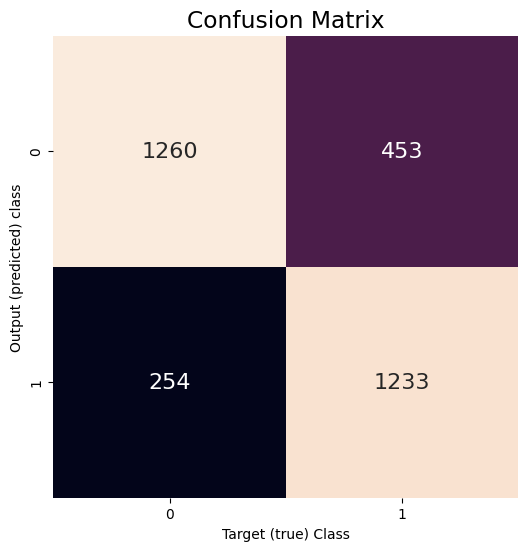

: 

In [19]:
confusion = confusion_matrix(labels, predictions)

plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(confusion, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)  # font size
plt.xlabel("Target (true) Class")
plt.ylabel("Output (predicted) class")
plt.title("Confusion Matrix")
plt.show()

plt.savefig("confusion_matrix.png")